<a href="https://colab.research.google.com/github/lennymelnik/pb_dataChallenge/blob/master/LSTM-V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Predicting Returns

Team A

This Version was created by Leonard Melnik

### First I imported all the librarys that I will need



In [0]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division

import warnings
warnings.filterwarnings("ignore")

#import Keras
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Data Preprocessing
##### The Delivery Volume is a modified version of the data we were given. I removed the first three days because they lacked any substancial data and would pollute any results

##### I also decided to import the Dow Jones, just incase its data would prove its correlation

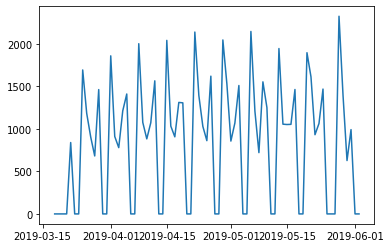

In [197]:
df_volume = pd.read_csv('https://raw.githubusercontent.com/lennymelnik/pb_dataChallenge/master/data/Delivery_Volume1.csv', index_col=['DELIVERY_DATE'], parse_dates=['DELIVERY_DATE'])
df_dji = pd.read_csv('https://raw.githubusercontent.com/lennymelnik/pb_dataChallenge/master/data/DJI.csv')


df_dji = df_dji.set_index('Date')

idx = pd.date_range('03-18-2019', '06-02-2019')
df_dji.index = pd.DatetimeIndex(df_dji.index)
df_dji = df_dji.reindex(idx, fill_value=0)

df_volume.sort_index(inplace=True)

df_volume['dji'] = df_dji['Adj Close']

df_volume=df_volume.fillna(0)

plt.plot(df_volume.index.values, df_volume['DELIVERED_VOLUME'])
plt.show()

# What I was able to understand from the data
If you look at the plot above, you can see that after there are no returns, there will always be a spike. And that spike is going to be the highest amount of returns that will happen that week.

The longer people cannot return products, the higher the spike will be. 

If you look at the last spike you can see it is much higher than the others. This is because it was memorial day weekend. Where people were unable to return anything for a longer period of time. So they had more saved up to return.

In [0]:
date_dataFrame = pd.to_datetime(df_volume.index.values)

weekdayArr = []
toDrop = []
for i in range(len(df_volume.DELIVERED_VOLUME)):
    
    weekday = date_dataFrame[i].weekday()
    #if(weekday == 6 or weekday == 5):
    #  toDrop.append(df_volume.index[i])
    weekdayArr.append(date_dataFrame[i].weekday())

df_volume['Weekday'] = weekdayArr

#df_volume = df_volume.drop(toDrop, axis=0)


In [0]:


#create a new dataframe to model the difference
df_diff = df_volume.copy()
#add previous sales to the next row
df_diff['prev_vol'] = df_diff['DELIVERED_VOLUME'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['DELIVERED_VOLUME'] - df_diff['prev_vol'])

plt.plot(df_diff.index.values, df_diff['diff'])


In [0]:

#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_vol'],axis=1)
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

df_supervised.head(80)


In [0]:

# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
#model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11 +lag_12', data=df_supervised).fit()
model = smf.ols(formula='DELIVERED_VOLUME ~ Facility_A + Facility_B + Facility_C + Facility_D + Facility_E + Facility_F + Facility_G + Facility_H + Facility_I + Weekday  + dji', data=df_supervised).fit()
# Fit the regression



# Extract the adjusted r-squared
regression_adj_rsq = model.rsquared_adj
print(regression_adj_rsq)

print(df_supervised)